<a href="https://colab.research.google.com/github/fioravantebossi/ML/blob/main/project1_transfering_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Transfer Learning Project in Python**

The project consists of applying the Transfer Learning method to a Deep Learning network in the Python language within the Colab environment.

As an example, we will use the following project which performs Transfer Learning with the MNIST dataset: https://colab.research.google.com/github/kylemath/ml4a-guides/blob/master/notebooks/transfer-learning.ipynb

The dataset used includes two classes: cats and dogs. A description of the dataset can be viewed at this link:
https://www.tensorflow.org/datasets/catalog/cats_vs_dogs

The download for the dataset can be accessed through this link:
https://www.microsoft.com/en-us/download/details.aspx?id=54765

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from PIL import Image, UnidentifiedImageError
import random as random
import keras
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from keras.models import Model


Downloading the dataset.

In [ ]:
!echo "Downloading Cats and Dogs"
!curl -L -o catsanddogs.zip --progress-bar https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!rm -fR PetImages
!unzip -o catsanddogs.zip
!rm catsanddogs.zip
!ls
!pwd

Streaming output truncated to the last 5000 lines.
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  
  inflating: PetImages/Dog/5522.jpg  
  inflating: PetImages/Dog/5523.jpg  
  inflating: PetImages/Dog/5524.jpg  

Mapping the classes.

In [ ]:
root = 'PetImages'
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['PetImages/Cat', 'PetImages/Dog']


Limiting the number of images for avoid memory overflows on Colab. Below function will delete aleatory images and keep just 300 images.

In [ ]:
#Limiting number of images for avoid memory overflow on Colab
def keep_random_files(directory, keep_count=300):
    # List all files in the directory (you can filter by extension if needed)
    files = os.listdir(directory)

    # Shuffle to pick random files
    random.shuffle(files)

    # If there aren't enough files, it won't delete any (or you can handle this differently)
    if len(files) <= keep_count:
        print(f"Directory '{directory}' has {len(files)} file(s). Nothing to delete.")
        return

    # We'll keep the first 'keep_count' shuffled files
    keep_files = set(files[:keep_count])

    # Delete the rest
    for f in files[keep_count:]:
        file_path = os.path.join(directory, f)
        if os.path.isfile(file_path):
            os.remove(file_path)
            print(f"Deleted: {file_path}")

    print(f"Kept {keep_count} files in '{directory}', removed {len(files) - keep_count}.")


dir1 = "PetImages/Dog"
dir2 = "PetImages/Cat"

keep_random_files(dir1, keep_count=300)
keep_random_files(dir2, keep_count=300)


Streaming output truncated to the last 5000 lines.
Deleted: PetImages/Cat/10542.jpg
Deleted: PetImages/Cat/7087.jpg
Deleted: PetImages/Cat/535.jpg
Deleted: PetImages/Cat/8736.jpg
Deleted: PetImages/Cat/10448.jpg
Deleted: PetImages/Cat/4938.jpg
Deleted: PetImages/Cat/9585.jpg
Deleted: PetImages/Cat/12045.jpg
Deleted: PetImages/Cat/8155.jpg
Deleted: PetImages/Cat/411.jpg
Deleted: PetImages/Cat/9474.jpg
Deleted: PetImages/Cat/8086.jpg
Deleted: PetImages/Cat/7489.jpg
Deleted: PetImages/Cat/9136.jpg
Deleted: PetImages/Cat/4136.jpg
Deleted: PetImages/Cat/6450.jpg
Deleted: PetImages/Cat/7063.jpg
Deleted: PetImages/Cat/11077.jpg
Deleted: PetImages/Cat/6674.jpg
Deleted: PetImages/Cat/9896.jpg
Deleted: PetImages/Cat/10724.jpg
Deleted: PetImages/Cat/5089.jpg
Deleted: PetImages/Cat/9020.jpg
Deleted: PetImages/Cat/7188.jpg
Deleted: PetImages/Cat/11675.jpg
Deleted: PetImages/Cat/7159.jpg
Deleted: PetImages/Cat/5452.jpg
Deleted: PetImages/Cat/11714.jpg
Deleted: PetImages/Cat/11647.jpg
Deleted: PetIma

Function to load images.

In [ ]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Somefiles/images on this dataset were empty or corrupted, so below function will delete files on these conditions.

In [ ]:
def remove_empty_or_corrupted_jpg(filename):

    if os.path.exists(filename):
      try:
        with open(filename, 'rb') as f:
          data = f.read()
      except FileNotFoundError:
          print(f"File not found, skipping: {filename}")
      if os.path.getsize(filename) == 0:
        print(f"Removing empty file: {filename}")
        os.remove(filename)
      else:
        try:
            with Image.open(filename) as img:
                # If Pillow can load the file, it's (most likely) not corrupted
                img.verify()  # Double check integrity
        except (UnidentifiedImageError, OSError) as e:
            # If we hit an error, the file is corrupted or not a valid JPEG
            print(f"Removing corrupted file: {filename} - {e}")
            os.remove(filename)


Load all the images from root folder.

In [ ]:
data = []

def get_images_list():
   images = [os.path.join(dp, f) for dp, dn, filenames
            in os.walk(category) for f in filenames
            if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
   return images

for c, category in enumerate(categories):
    images = get_images_list()

    #validate images first
    for img_path in images:
      remove_empty_or_corrupted_jpg(img_path)

    images = get_images_list()

    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

Randomize the data order.

In [ ]:
random.shuffle(data)

Create training / validation / test split (70%, 15%, 15%)

In [ ]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Separate data for labels.

In [ ]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1]


Pre-process the data by making sure it's float32 and normalized between 0 and 1.

In [ ]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(90, 2)


Let's get a summary of what we have.

In [ ]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 600 images from 2 categories
train / validation / test split: 420, 90, 90
training data shape:  (420, 224, 224, 3)
training labels shape:  (420, 2)


Let's quickly look at a few sample images from our dataset.

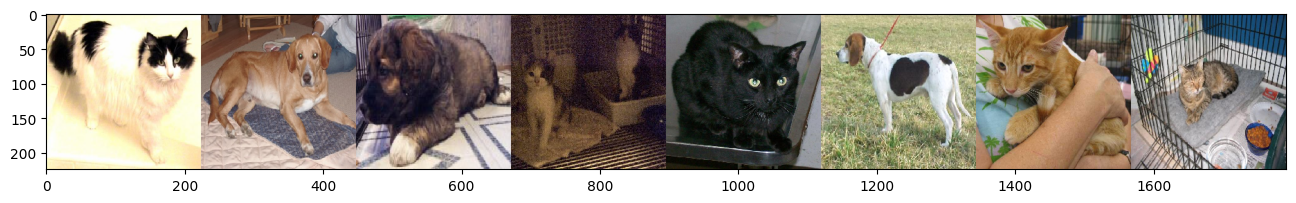

In [ ]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

Now we can move on to the main strategy for training an image classifier on our small dataset: by starting with a larger and already trained network.

To start, we will load the VGG16 from keras, which was trained on ImageNet and the weights saved online. If this is your first time loading VGG16, you'll need to wait a bit for the weights to download from the web. Once the network is loaded, we can again inspect the layers with the summary() method.

In [ ]:
#Transfering learning
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In order to use this network for our task, we "remove" the final classification layer, the 1000-neuron softmax layer at the end, which corresponds to ImageNet, and instead replace it with a new softmax layer for our dataset.

In terms of implementation, it's easier to simply create a copy of VGG from its input layer until the second to last layer, and then work with that, rather than modifying the VGG object directly. So technically we never "remove" anything, we just circumvent/ignore it. This can be done in the following way, by using the keras Model class to initialize a new model whose input layer is the same as VGG but whose output layer is our new softmax layer, called new_classification_layer. Note: although it appears we are duplicating this large network, internally Keras is actually just copying all the layers by reference, and thus we don't need to worry about overloading the memory.

In [ ]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

So we go ahead and freeze the layers, and compile the model.

In [ ]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

We go ahead and train the new model.

In [ ]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=15,
                         validation_data=(x_val, y_val))

Epoch 1/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4518 - loss: 1.1132 - val_accuracy: 0.4333 - val_loss: 1.3939
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 614ms/step - accuracy: 0.5117 - loss: 0.9933 - val_accuracy: 0.5667 - val_loss: 0.7951
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step - accuracy: 0.5188 - loss: 0.8256 - val_accuracy: 0.4333 - val_loss: 0.7457
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step - accuracy: 0.5174 - loss: 0.7079 - val_accuracy: 0.8222 - val_loss: 0.5247
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step - accuracy: 0.6768 - loss: 0.5976 - val_accuracy: 0.7667 - val_loss: 0.5011
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 680ms/step - accuracy: 0.7635 - loss: 0.5113 - val_accuracy: 0.5556 - val_loss: 0.6029
Epoch 7/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 684ms/step - accuracy: 0.6714 - loss: 0.5286 - val_accuracy: 0.8222 - val_loss: 0.4394
Epoch 8/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 676ms/step - accuracy: 0.7712 - loss: 0.4814 - val_accuracy: 0.8556 - val_loss: 0.

We do a final validation on the test set.

In [ ]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.3223487138748169
Test accuracy: 0.8777777552604675


Some basic testing, predicting with images that are not part of dataset.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Probabilities: [[0.26413104 0.73586893]]
Predict: It is a dog


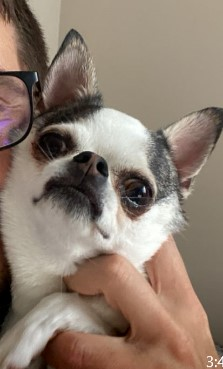

In [ ]:
from IPython.display import Image,display

# Setting class names
class_names = ["cat", "dog"]

# getting prediction of probabilities
img_path = "Test_Image/Lino.jpg"
img, x = get_image(img_path)
probabilities = model_new.predict([x])

# finding the class index with higher probabilitie
predicted_class_index = probabilities.argmax()

# Converting index to class name
predicted_class_name = class_names[predicted_class_index]

print(f"Probabilities: {probabilities}")
print(f"Predict: It is a {predicted_class_name}")

display(Image(filename=img_path))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Probabilities: [[1.0000000e+00 2.7040501e-08]]
Predict: It is a cat


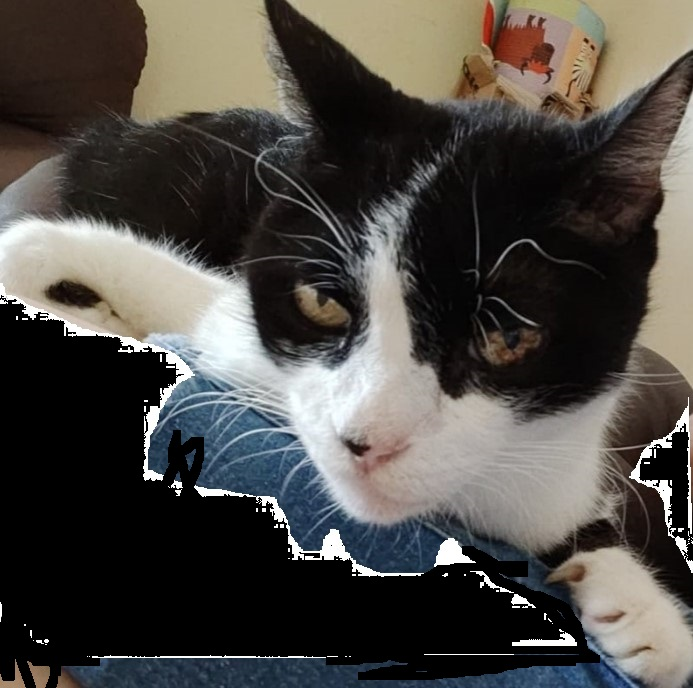

In [ ]:
# getting prediction of probabilities
img_path = "Test_Image/Bibiu.jpg"
img, x = get_image(img_path)
probabilities = model_new.predict([x])

# finding the class index with higher probabilitie
predicted_class_index = probabilities.argmax()

# Converting index to class name
predicted_class_name = class_names[predicted_class_index]

print(f"Probabilities: {probabilities}")
print(f"Predict: It is a {predicted_class_name}")

display(Image(filename=img_path))

**Improving the results**

It was possible to reach around 88% of accuracy, is a pretty good achievement.
Some techniques which possibly could have improved our performance:

* Using data augementation: augmentation refers to using various modifications of the original training data, in the form of distortions, rotations, rescalings, lighting changes, etc to increase the size of the training set and create more tolerance for such distortions.

* Using a different optimizer, adding more regularization/dropout, and other hyperparameters.

* Training for longer (additional epochs).

* Training with bigger dataset (without limitations of Colab).



